# Benchmarking algorithms 

Algorithms differ in how they define biclusters. Some of the common types include:
- constant values, constant rows, or constant columns
- unusually high or low values
- submatrices with low variance
- correlated rows or columns

Algorithms also differ in how rows and columns may be assigned to biclusters, which leads to different bicluster structures. Block diagonal or checkerboard structures occur when rows and columns are divided into partitions.

If each row and each column belongs to exactly one bicluster, then rearranging the rows and columns of the data matrix reveals the biclusters on the diagonal. 

In the checkerboard case, each row belongs to all column clusters, and each column belongs to all row clusters.

### Bicluster Taxonomy

Several types of biclusters have been described and categorised in the literature, depending on
the pattern exhibited by the genes across the experimental conditions.
* **Constant values**: A bicluster with constant values reveals subsets of genes with similar ex-
pression values within a subset of conditions. 
* **Constant values on rows or columns**: A bicluster with constant values in the rows/columns identifies a subset of genes/conditions with similar expression levels across a subset
of conditions/genes. Expression levels might therefore vary from gene to gene or from condition to condition. 
* **Coherent values on both rows and columns**: This kind of bicluster identifies more complex relationships between genes and conditions, either in an additive or multiplicative way-
* **Coherent evolutions**: Evidence that a subset of genes is up-regulated or down-regulated
across a subset of conditions without taking into account their actual expression values. In
this situation, data in the bicluster do not follow any mathematical model.

### Shifting and Scaling Expression Patterns

Possible patterns in gene expression data (does not necessarily apply to Bonferroni corrected p-values). Shifting and scaling patterns are defined using numerical relationships between the values in a bicluster. 
* **Perfect shifting pattern**: The bicluster values can be obtained by adding a constant condition number to a typical value for each gene.
* **Perfect scaling patterns**: The biclsuter values can be obtained by multiplying a typical value for the gene by a scaling coefficient. In this case, the genes do not follow a paral-
lel tendency. Although the genes present the same behaviour with regard to the regulation,
changes are more abrupt for some genes than for others.
* **Perfect shifting and scaling patterns**: A bicluster includes a shifting, a scaling or both shifting and scaling patterns.

### Scoring metrics

There are two ways of evaluating a biclustering result: internal and external. Internal measures, such as cluster stability, rely only on the data and the result themselves. 

* **Silhouette score**: The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

External measures refer to an external source of information, such as the true solution. When working with real data the true solution is usually unknown, but biclustering artificial data may be useful for evaluating algorithms precisely because the true solution is known.

To compare a set of found biclusters to the set of true biclusters, two similarity measures are needed: a similarity measure for individual biclusters, and a way to combine these individual similarities into an overall score.

* **Jaccard index**: The Jaccard index achieves its minimum of 0 when the biclusters to not overlap at all and its maximum of 1 when they are identical.

In [1]:
import os

import testsets
import algorithms
import model_selection

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster.bicluster import SpectralCoclustering

# To specify `fit model` param of R Plaid algorithm.
import rpy2.robjects as robjects

plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'white'

%matplotlib inline

/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **

/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  

/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return

/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  

/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/severinlangberg/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return

In [2]:
def model_dump(exp_id, experiment, parent='./../model_dumps/'):
    
    for test_class in experiment.best_models.keys():
        stem = ('').join((exp_id, test_class, '.pkl'))
        joblib.dump(
            experiment.best_models[test_class][1], 
            os.path.join(parent, stem)
        )

In [3]:
# Globals
SEEDS = [0, 1]

## Test data gallery

Load characteristics of reference data 

In [4]:
data_feats = pd.read_csv(
    './../data/data_id/data_characteristics.csv', sep='\t', index_col=0
)
data_feats

,max,min,std,nrows,ncols,nonzeros
orig_prep_pvalues,73.435290,7.079401e-09,5.889983,2664,27561,73422504
sel_prep_pvalues,73.435290,0.000000e+00,2.897937,2664,27561,739608
orig_prep_pcc,0.852443,-8.669647e-01,0.323260,2664,27561,73422504
sel_prep_pcc,0.852443,-8.669647e-01,0.063930,2664,27561,739608


Generate samples of test data displaying the characteristics of each class of reference data

In [5]:
sample_data, _, _ = testsets.gen_test_sets(
    data_feats, sparse=[False, True, False, True],
    non_neg=[True, True, False, False],
    shape=(500, 300), n_clusters=3, seed=0
)

Display the the test sample data

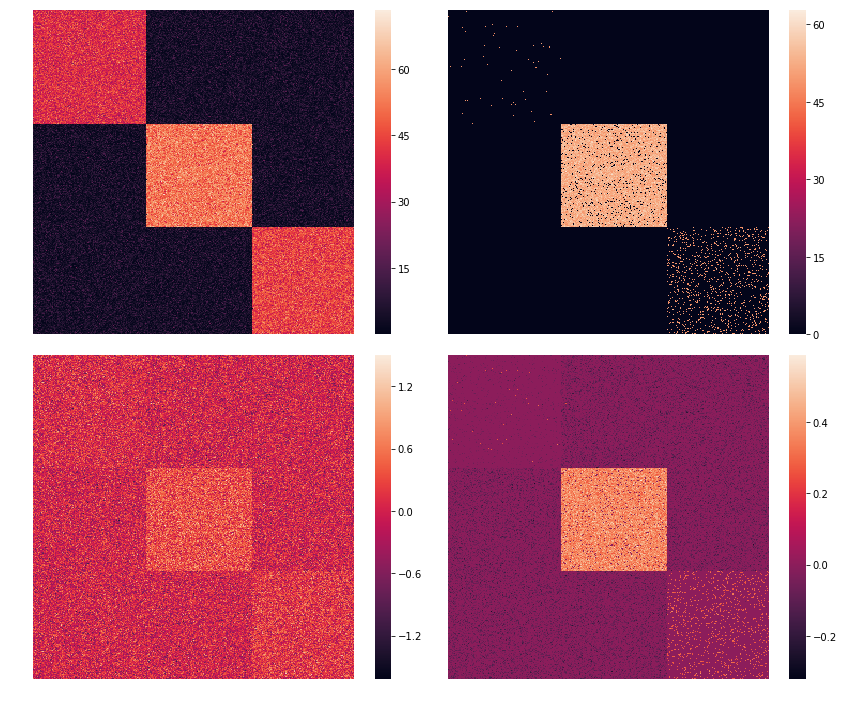

In [6]:
nrows, ncols = 2, 2
labels = list(sample_data.keys())

fig, axes = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(12, 10), sharey=True, sharex=True
)
num = 0
for row in range(nrows):
    for col in range(ncols):
        _data = sample_data[labels[num]]
        sns.heatmap(
            _data, ax=axes[row, col], cbar=True,
            vmin=np.min(_data), vmax=np.max(_data)
        )
        #axes[row, col].set_title(labels[num])
        axes[row, col].axis('off')
        
        num += 1
        
plt.tight_layout()

When shuffled, the test data should resemble the reference data

In [7]:
# TODO: compare shuffled test data to reference data

## Experiments

To determine which model is best applicable to each class of test data using the optimal hyperparameter settings. Generate fixed size test data with varying number of clusters

In [8]:
# NOTE: The reference data contains approx. ten times more rows than columns.
array_size = (100, 1000)
var_num_clusters = [2, 3, 4, 5, 6]

# NOTE: Each list element is a tuple of data, rows, cols
cluster_exp_data = [
    testsets.gen_test_sets(
        data_feats, sparse=[False, True, False, True], 
        non_neg=[True, True, False, False],
        shape=array_size, n_clusters=n_clusters, seed=SEEDS[0]
    ) 
    for n_clusters in var_num_clusters
]

### Experiment: scikit-learn spectral algorhtms

Setup scikit-learn algorithms and hyperparameter grids

In [9]:
sk_models_and_params = [
    (
        SpectralBiclustering, {
            'method': ['log', 'bistochastic', 'scale'], 
            'n_components': [6, 12, 18], 
            'mini_batch': [True, False],
            'n_init': [10, 30, 50]
        }
    ),
    (
        SpectralCoclustering, {
            'mini_batch': [True, False],
            'n_init': [10, 30, 50]
        }
    )
]

Run repeated experiments with four classes of test data

In [ ]:
# NOTE: Option to run verbose.
sk_multi_exper = model_selection.MultiExperiment(
    sk_models_and_params, verbose=0, random_states=SEEDS
)
sk_multi_exper.execute_all(
    cluster_exp_data, data_feats.index
)

In [ ]:
print('Performance report sklearn models:\n')
print(sk_multi_exper.performance_report)

In [ ]:
# Write instances of winning models to disk.
model_dump(exp_id='sk_', experiment=sk_multi_exper)

### Experiment: R biclust algorithms

Setup R algorithms and hyperparameter grids. see [R biclust docs](https://cran.r-project.org/web/packages/biclust/biclust.pdf) for param description.

In [ ]:
r_models_and_params = [
    (
        algorithms.Quest, {
            'ns': [10, 50, 100],
            'nd': [5, 10, 50],
            'sd': [3, 5, 10],
            'alpha': [0.025, 0.05, 0.1],
            'quant': [0.1, 0.2, 0.3],
        }
    ), (
        algorithms.Bimax, {
            'minr': [50, 100, 500],
            'minc': [50, 100, 500],
            'maxc': [1e3, 1e4, 1e5]
        }
    ), (
        algorithms.ChengChurch, {
            'delta': [0.1, 0.5, 1.0, 1.5],
            'alpha': [0.025, 0.05, 0.1],
        }
    ), (
        algorithms.Plaid, {
            'cluster': ['r', 'c', 'b'],
            'fit_model': [
                robjects.r('y ~ m + a + b'),
                robjects.r('y ~ (a - b)^2 / (2 * m^2)')
            ],
            'background': [True, False],
            'row_release': [0.3, 0.5, 0.7],
            'col_release': [0.3, 0.5, 0.7],
            'back_fit': [4, 7, 10],
            'max_layers': [20, 30, 100],
            'iter_startup': [5, 10, 15],
            'iter_layer': [5, 10, 15],
        }
    ), (
        algorithms.Xmotifs, {
            'ns': [50, 100, 500, 1e3],
            'nd': [5, 10, 20],
            'sd': [5, 10],
            'alpha': [0.025, 0.05, 0.1],
        }
    ), (
        algorihms.Spectral, {
            'normalization': ['log', 'irrc', 'bistochastization'],
            'numberOfEigenvalues': [3, 5, 8],
            'minr': [50, 100, 500],
            'minc': [50, 100, 500],
            'withinVar': [1, 5, 7, 10]
        }
    )
]

Run experiment

In [ ]:
# NOTE: Option to run verbose.
r_multi_exper = model_selection.MultiExperiment(
    r_models_and_params, verbose=0, random_states=SEEDS
)
r_multi_exper.execute_all(
    cluster_exp_data, data_feats.index
)

In [ ]:
print('Performance report R models:\n')
print(r_multi_exper.performance_report)

In [ ]:
# Write instances of winning models to disk.
model_dump(exp_id='r_', experiment=r_multi_exper)